# Generational changes in religious attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from scipy.special import expit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
# !wget https://gssdataexplorer.norc.org/extracts/21438/download

In [3]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [4]:
# TODO: find out what code 4 is

gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)

In [5]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

In [6]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)

In [7]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

In [8]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [9]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

In [10]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [11]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [12]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [13]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 11)

We drop 471 records due to missing data.

In [14]:
62466 - 61995

471

Here's the distribution of ages.

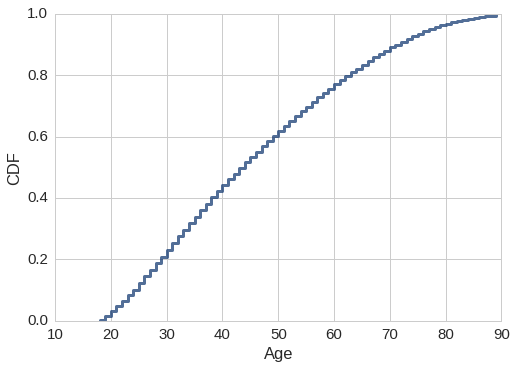

In [15]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [16]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5)

Here's the distribution of birth year.

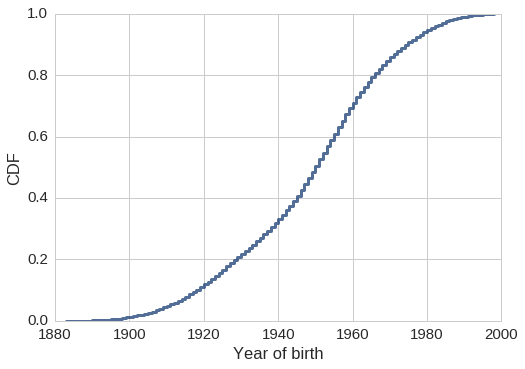

In [17]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [18]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5) + 2.5

In [19]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the distribution of religion codes.

In [20]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [21]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god,age_group,cohort5,cohort10
0,1972,NaN,NaN,1946.0,26.0,1.3339,0,2.0,0,1166,NaN,25.0,1947.5,1940.0
1,1972,NaN,NaN,1915.0,57.0,0.8893,0,1.0,4,136,NaN,55.0,1917.5,1910.0
2,1972,NaN,NaN,1906.0,66.0,0.8893,0,1.0,9,1195,NaN,65.0,1907.5,1900.0
3,1972,NaN,NaN,1945.0,27.0,1.7786,0,2.0,8,321,NaN,25.0,1947.5,1940.0
4,1972,NaN,NaN,1927.0,45.0,1.7786,0,2.0,10,827,NaN,45.0,1927.5,1920.0


## How does religious affiliation change with age?

In [22]:
varnames = ['prot', 'cath', 'none', 'other']

def create_relig_vars(df):
    # the second line lumps "Orthodox-Christian" and "Christian" with Protestant
    df['prot'] = (df.relig==1)
    df['prot'] = (df.relig.isin([1,10,11]))

    df['cath'] = (df.relig==2)
    df['none'] = (df.relig==4)
    df['other'] = (df.relig.isin([3,5,6,7,8,9,10,11,12,13]))

    df.loc[df.relig.isnull(), varnames] = np.nan
    
create_relig_vars(sample)

Group by decade of birth and age group.

In [23]:
grouped = sample.groupby(['cohort10', 'age_group'])

Count the number of observations in each decade/age group.

In [24]:
counts = grouped.none.count().unstack()
counts

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,42.0
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,168.0,152.0,104.0
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,405.0,507.0,305.0,218.0,174.0
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,606.0,728.0,693.0,629.0,433.0,235.0,211.0
1920.0,NaN,NaN,NaN,NaN,NaN,89.0,720.0,1009.0,921.0,913.0,796.0,573.0,456.0,298.0,186.0
1930.0,NaN,NaN,NaN,83.0,607.0,997.0,1007.0,916.0,787.0,736.0,657.0,475.0,384.0,169.0,21.0
1940.0,NaN,116.0,840.0,1129.0,1151.0,1344.0,1355.0,1215.0,1058.0,884.0,640.0,310.0,37.0,NaN,NaN
1950.0,326.0,1557.0,1587.0,1654.0,1683.0,1571.0,1583.0,1254.0,1056.0,543.0,86.0,NaN,NaN,NaN,NaN
1960.0,339.0,1561.0,1568.0,1585.0,1560.0,1454.0,1093.0,739.0,87.0,NaN,NaN,NaN,NaN,NaN,NaN


Compute the percentage of Nones in each group.

In [25]:
percent_none = grouped.none.mean().unstack()
percent_none

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.053571,0.019737,0.019231
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.027160,0.047337,0.042623,0.041284,0.017241
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025641,0.033003,0.021978,0.028860,0.057234,0.030023,0.021277,0.052133
1920.0,NaN,NaN,NaN,NaN,NaN,0.056180,0.051389,0.020813,0.032573,0.021906,0.045226,0.050611,0.081140,0.073826,0.075269
1930.0,NaN,NaN,NaN,0.060241,0.052718,0.045135,0.047666,0.040393,0.029225,0.055707,0.074581,0.084211,0.049479,0.088757,0.095238
1940.0,NaN,0.129310,0.107143,0.075288,0.092094,0.087798,0.083395,0.089712,0.091682,0.097285,0.115625,0.096774,0.108108,NaN,NaN
1950.0,0.128834,0.092486,0.115942,0.090689,0.093286,0.127944,0.135186,0.132376,0.139205,0.154696,0.127907,NaN,NaN,NaN,NaN
1960.0,0.174041,0.117873,0.124362,0.124290,0.153205,0.132050,0.175663,0.173207,0.114943,NaN,NaN,NaN,NaN,NaN,NaN


Drop cells where we have fewer than 50 observations.

In [26]:
percent_none[counts < 50] = np.nan

Select rows for people born in the 1930s through 1980s.

In [27]:
decades = np.linspace(1930, 1980, 6, endpoint=True)
percent_none.loc[decades]

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
cohort10,,,,,,,,,,,,,,,
1930.0,NaN,NaN,NaN,0.060241,0.052718,0.045135,0.047666,0.040393,0.029225,0.055707,0.074581,0.084211,0.049479,0.088757,NaN
1940.0,NaN,0.129310,0.107143,0.075288,0.092094,0.087798,0.083395,0.089712,0.091682,0.097285,0.115625,0.096774,NaN,NaN,NaN
1950.0,0.128834,0.092486,0.115942,0.090689,0.093286,0.127944,0.135186,0.132376,0.139205,0.154696,0.127907,NaN,NaN,NaN,NaN
1960.0,0.174041,0.117873,0.124362,0.124290,0.153205,0.132050,0.175663,0.173207,0.114943,NaN,NaN,NaN,NaN,NaN,NaN
1970.0,0.134948,0.181545,0.189621,0.193023,0.207182,0.220421,0.159091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980.0,0.199422,0.285595,0.294971,0.266667,0.301887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Choose some colors.

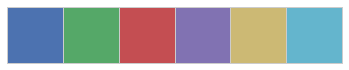

In [28]:
colors = sns.color_palette()
sns.palplot(colors)

For each birth cohort, plot the percentage of Nones as a function of age.

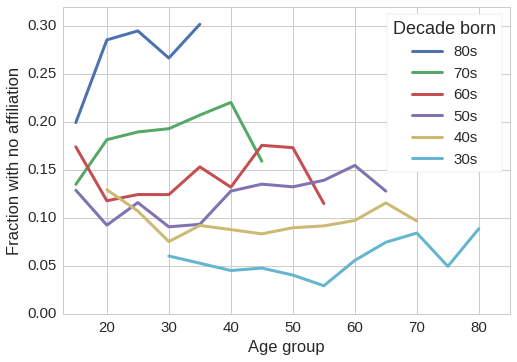

In [29]:
options = dict(alpha=1)

thinkplot.preplot(6)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.plot(percent_none.loc[1950], label='50s', color=colors[3], **options)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)

xlabel = 'Age group'
ylabel = 'Fraction with no affiliation'
axis = [13, 85, 0, 0.32]

thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, legend=True)
plt.gca().get_legend().set(title='Decade born');

Same as the previous, but as a multi-plot.

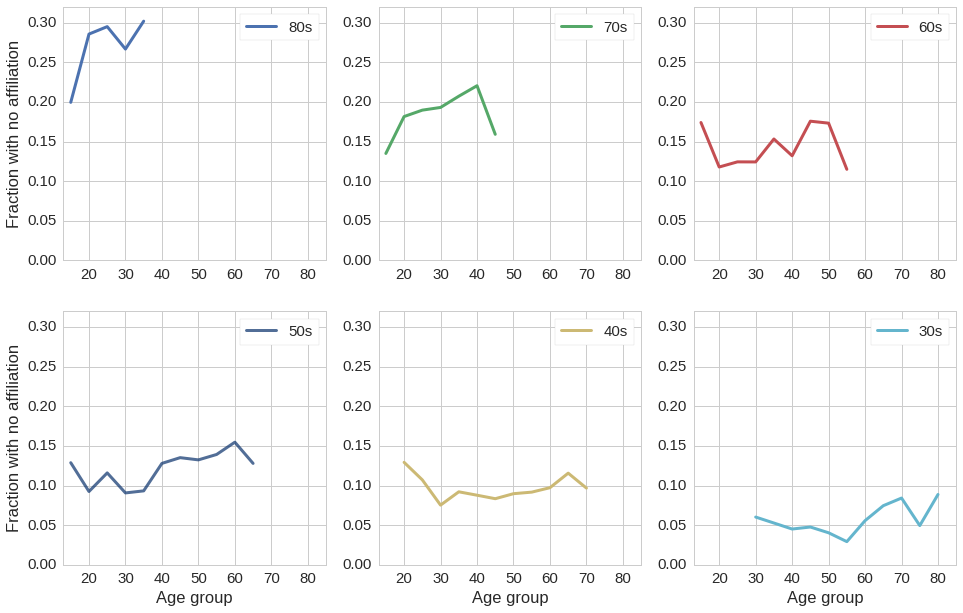

In [30]:
thinkplot.preplot(num=6, rows=2, cols=3)
thinkplot.subplot(1)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.config(ylabel=ylabel, axis=axis)

thinkplot.subplot(2)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(3)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(4)
thinkplot.plot(percent_none.loc[1950], label='50s')
thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, color=colors[3], **options)

thinkplot.subplot(5)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

thinkplot.subplot(6)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

## Generational replacement

Choose colors

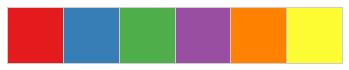

In [31]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(sns.color_palette('Set1'))

In [32]:
def make_series_seq(grouped, varnames):
    return [grouped[var].mean() * 100 for var in varnames]

def plot_series_seq(series_seq, colors, labels):
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [33]:
colors = [ORANGE, GREEN, RED, BLUE]
    
def plot_relig(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of interview year.

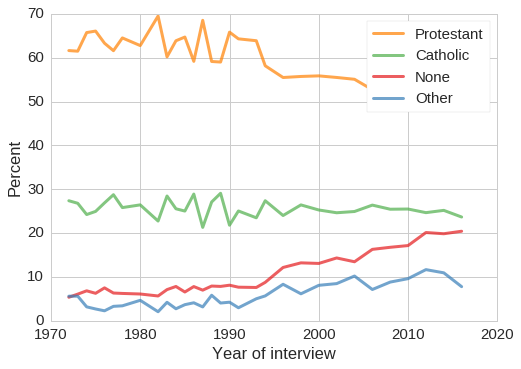

In [34]:
grouped_year = sample.groupby(['year'])
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of interview', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

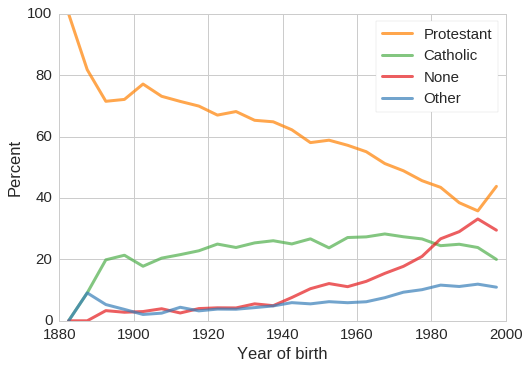

In [35]:
grouped_cohort = sample.groupby(['cohort5'])
plot_relig(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

Before running models, center the factors we're planning to use.

In [36]:
def center_factors(df):
    """Center factors around their means.
    
    df: DataFrame
    """
    df['cohort66'] = df.cohort - 1966
    df['cohort662'] = df.cohort66**2 / 1966

In [37]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god,age_group,cohort5,cohort10,prot,cath,none,other,cohort66,cohort662
0,1972,NaN,NaN,1946.0,26.0,1.3339,0,2.0,0,1166,NaN,25.0,1947.5,1940.0,0.0,1.0,0.0,0.0,-20.0,0.203459
1,1972,NaN,NaN,1915.0,57.0,0.8893,0,1.0,4,136,NaN,55.0,1917.5,1910.0,1.0,0.0,0.0,0.0,-51.0,1.322991
2,1972,NaN,NaN,1906.0,66.0,0.8893,0,1.0,9,1195,NaN,65.0,1907.5,1900.0,1.0,0.0,0.0,0.0,-60.0,1.831129
3,1972,NaN,NaN,1945.0,27.0,1.7786,0,2.0,8,321,NaN,25.0,1947.5,1940.0,0.0,1.0,0.0,0.0,-21.0,0.224313
4,1972,NaN,NaN,1927.0,45.0,1.7786,0,2.0,10,827,NaN,45.0,1927.5,1920.0,0.0,1.0,0.0,0.0,-39.0,0.773652


Run logistic regression to fit models to each religious group.

In [38]:
def make_model(df, var):
    formula = var + ' ~ cohort66 + cohort662'
    return smf.logit(formula, data=df).fit()

In [39]:
make_model(sample, 'prot').summary()

Optimization terminated successfully.
         Current function value: 0.664625
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                 0.02131
Time:                        16:22:12   Log-Likelihood:                -41203.
converged:                       True   LL-Null:                       -42101.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0741      0.010      7.075      0.000       0.054       0.095
cohort66      -0.0200      0.001    -27.756      0.000      -0.021      -0.019
cohort662     -0.1640      0.031     -5.242      0.000      -0.225      -0.103
==============================================================================
"""

In [40]:
make_model(sample, 'cath').summary()

Optimization terminated successfully.
         Current function value: 0.567402
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                0.001281
Time:                        16:22:12   Log-Likelihood:                -35176.
converged:                       True   LL-Null:                       -35221.
                                        LLR p-value:                 2.547e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0103      0.012    -85.823      0.000      -1.033      -0.987
cohort66      -0.0009      0.001     -1.124      0.261      -0.002       0.001
cohort662     -0.2146      0.035     -6.137      0.000      -0.283      -0.146
==============================================================================
"""

In [41]:
make_model(sample, 'none').summary()

Optimization terminated successfully.
         Current function value: 0.332795
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                 0.05802
Time:                        16:22:13   Log-Likelihood:                -20632.
converged:                       True   LL-Null:                       -21902.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6891      0.015   -110.568      0.000      -1.719      -1.659
cohort66       0.0350      0.001     37.258      0.000       0.033       0.037
cohort662      0.1203      0.055      2.203      0.028       0.013       0.227
==============================================================================
"""

In [42]:
make_model(sample, 'other').summary()

Optimization terminated successfully.
         Current function value: 0.229253
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                 0.01597
Time:                        16:22:13   Log-Likelihood:                -14213.
converged:                       True   LL-Null:                       -14443.
                                        LLR p-value:                6.283e-101
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4966      0.020   -125.383      0.000      -2.536      -2.458
cohort66       0.0206      0.001     16.527      0.000       0.018       0.023
cohort662      0.1973      0.063      3.156      0.002       0.075       0.320
==============================================================================
"""

Use a fitted model to make a prediction.

In [43]:
def make_predictions(results):
    """Make a prediction based on a fitted model.
    
    results: RegressionResults object
    
    returns: Series that maps datas to predicted percentages
    """
    cohort = np.arange(1997, 2030)
    df = pd.DataFrame(dict(cohort=cohort))
    center_factors(df)
    pred = results.predict(df) * 100
    pred.index = cohort
    return pred

Plot predictions.

In [44]:
def plot_predictions(series_seq):
    """Plot a sequence of series.
    
    series_seq: list of series
    """
    alpha = 0.3
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)

Plot religious affiliation by cohort, with predictions

In [45]:
result_seq = [make_model(sample, var) for var in varnames]
series_seq = [make_predictions(results) for results in result_seq]

Optimization terminated successfully.
         Current function value: 0.664625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.332795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.229253
         Iterations 7


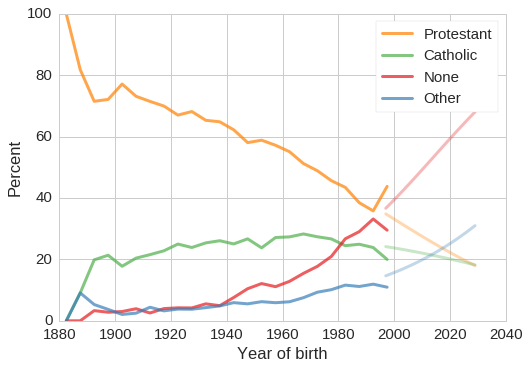

In [46]:
plot_relig(grouped_cohort)
plot_predictions(series_seq)

thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Predict population

Predict future generations based on the models.

In [47]:
def run_models(sample, result_seq, year, verbose=False):
    """Simulate future samples.
    
    sample: DataFrame, one row per respondent
    result_seq: list of RegressionResult objects
    year: number
    verbose: boolean, whether to print diagnostic info
    
    returns: Series that maps from religion to percentage
    """
    cohort = year - sample.age
    
    if verbose:
        # print the fraction of people in the simulated sample
        # who were actually observed
        print(np.mean(cohort<1997))

    df = pd.DataFrame(dict(cohort=cohort))
    center_factors(df)
    pred = [results.predict(df).mean() for results in result_seq]
    return pd.Series(pred, index=varnames) * 100

In [48]:
run_models(sample, result_seq, 2016)

prot     48.539923
cath     25.923791
none     20.127513
other     9.091366
dtype: float64

In [49]:
run_models(sample, result_seq, 2023)

prot     44.922588
cath     25.552831
none     24.323723
other    10.518701
dtype: float64

In [50]:
run_models(sample, result_seq, 2037)

prot     37.397171
cath     24.248421
none     34.499574
other    14.308306
dtype: float64

In [51]:
run_models(sample, result_seq, 2053)

prot     28.812819
cath     21.943629
none     48.342423
other    20.642016
dtype: float64

In [52]:
def predict_by_year(sample, result_seq, years):
    df = pd.DataFrame(columns=varnames)
    for year in years:
        df.loc[year] = run_models(sample, result_seq, year)
    return df

In [53]:
years = np.arange(1972, 2049)
df = predict_by_year(sample, result_seq, years)

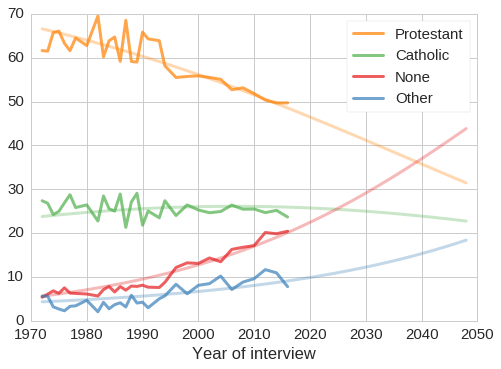

In [54]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Belief in God

In [55]:
varnames = ['strongbelief', 'belief', 'nobelief']

def create_belief_vars(df):
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))

    df.loc[df.god.isnull(), varnames] = np.nan
    
create_belief_vars(sample)

In [56]:
RED, PINK, _, _, LTBLUE, DKBLUE = sns.color_palette('RdBu', 6)
colors = [BLUE, PURPLE, RED]

In [57]:
def plot_beliefs(grouped):
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

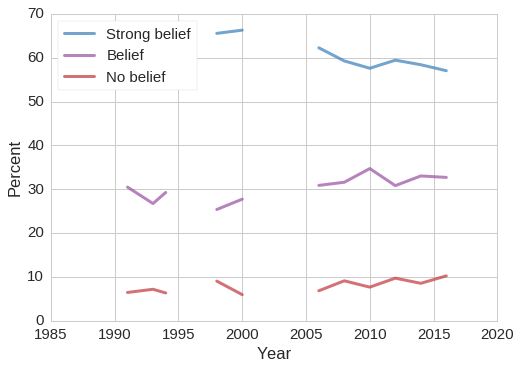

In [58]:
plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

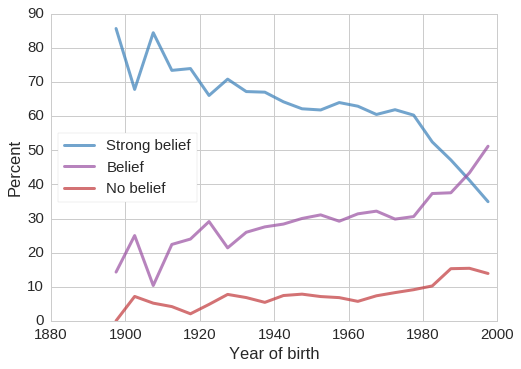

In [59]:
plot_beliefs(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='center left')

In [60]:
make_model(sample, 'strongbelief').summary()

Optimization terminated successfully.
         Current function value: 0.660882
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           strongbelief   No. Observations:                22325
Model:                          Logit   Df Residuals:                    22322
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                 0.01144
Time:                        16:22:18   Log-Likelihood:                -14754.
converged:                       True   LL-Null:                       -14925.
                                        LLR p-value:                 6.640e-75
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4148      0.017     24.624      0.000       0.382       0.448
cohort66      -0.0165      0.001    -17.271      0.000      -0.018      -0.015
cohort662     -0.3630      0.062     -5.856      0.000      -0.484      -0.242
==============================================================================
"""

In [61]:
make_model(sample, 'belief').summary()

Optimization terminated successfully.
         Current function value: 0.615714
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 belief   No. Observations:                22325
Model:                          Logit   Df Residuals:                    22322
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                0.005542
Time:                        16:22:18   Log-Likelihood:                -13746.
converged:                       True   LL-Null:                       -13822.
                                        LLR p-value:                 5.394e-34
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7640      0.018    -43.091      0.000      -0.799      -0.729
cohort66       0.0110      0.001     11.176      0.000       0.009       0.013
cohort662      0.1722      0.065      2.641      0.008       0.044       0.300
==============================================================================
"""

In [62]:
make_model(sample, 'nobelief').summary()

Optimization terminated successfully.
         Current function value: 0.274237
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               nobelief   No. Observations:                22325
Model:                          Logit   Df Residuals:                    22322
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                 0.01160
Time:                        16:22:18   Log-Likelihood:                -6122.3
converged:                       True   LL-Null:                       -6194.2
                                        LLR p-value:                 6.373e-32
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4603      0.031    -79.571      0.000      -2.521      -2.400
cohort66       0.0187      0.002     12.150      0.000       0.016       0.022
cohort662      0.5256      0.108      4.858      0.000       0.314       0.738
==============================================================================
"""

In [63]:
result_seq = [make_model(sample, var) for var in varnames]
series_seq = [make_predictions(results) for results in result_seq]

Optimization terminated successfully.
         Current function value: 0.660882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.274237
         Iterations 7


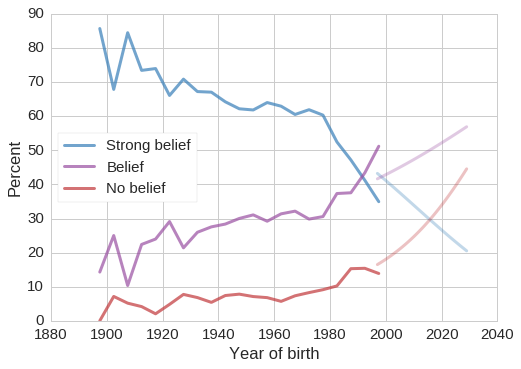

In [64]:
plot_beliefs(grouped_cohort)
plot_predictions(series_seq)

thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='center left')

In [65]:
run_models(sample, result_seq, 2016)

strongbelief    56.514711
belief          33.831148
nobelief         9.745838
dtype: float64

In [66]:
years = np.arange(1991, 2040)
df = predict_by_year(sample, result_seq, years)
df

,strongbelief,belief,nobelief
1991,64.786205,28.536209,6.667936
1992,64.567566,28.695435,6.726611
1993,64.339813,28.858803,6.789590
1994,64.102902,29.026346,6.856972
1995,63.856795,29.198092,6.928859
1996,63.601450,29.374074,7.005361
1997,63.336829,29.554322,7.086597
1998,63.062896,29.738868,7.172691
1999,62.779615,29.927744,7.263777
2000,62.486953,30.120980,7.359994


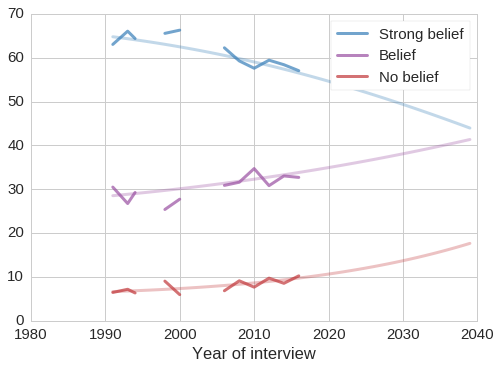

In [67]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)

plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [68]:
sum(sample.conclerg.isnull())

21269

In [69]:
varnames = ['confident', 'someconf', 'noconf']

def create_conf_vars(df):
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
    
create_conf_vars(sample)


In [70]:
def plot_conf(grouped):
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

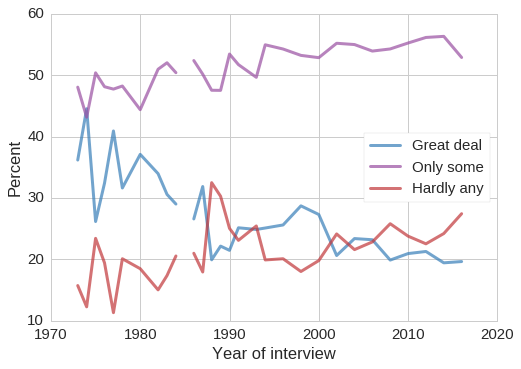

In [71]:
plot_conf(grouped_year)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

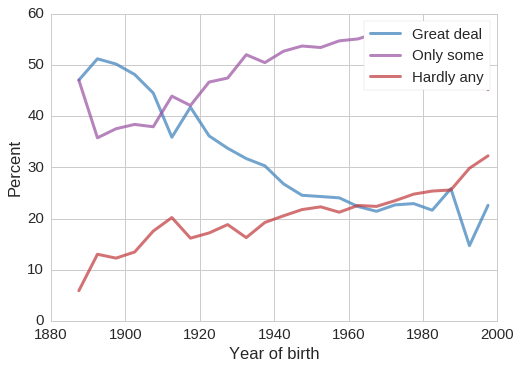

In [72]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [73]:
make_model(sample, 'confident').summary()

Optimization terminated successfully.
         Current function value: 0.578980
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              confident   No. Observations:                40726
Model:                          Logit   Df Residuals:                    40723
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                 0.01722
Time:                        16:22:21   Log-Likelihood:                -23580.
converged:                       True   LL-Null:                       -23993.
                                        LLR p-value:                3.438e-180
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2426      0.016    -79.527      0.000      -1.273      -1.212
cohort66      -0.0070      0.001     -6.794      0.000      -0.009      -0.005
cohort662      0.3383      0.040      8.481      0.000       0.260       0.416
==============================================================================
"""

In [74]:
make_model(sample, 'someconf').summary()

Optimization terminated successfully.
         Current function value: 0.689092
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               someconf   No. Observations:                40726
Model:                          Logit   Df Residuals:                    40723
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                0.005198
Time:                        16:22:22   Log-Likelihood:                -28064.
converged:                       True   LL-Null:                       -28211.
                                        LLR p-value:                 2.073e-64
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1846      0.013     13.974      0.000       0.159       0.210
cohort66      -0.0009      0.001     -1.056      0.291      -0.003       0.001
cohort662     -0.3652      0.036    -10.081      0.000      -0.436      -0.294
==============================================================================
"""

In [75]:
make_model(sample, 'noconf').summary()

Optimization terminated successfully.
         Current function value: 0.510357
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 noconf   No. Observations:                40726
Model:                          Logit   Df Residuals:                    40723
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                0.004258
Time:                        16:22:22   Log-Likelihood:                -20785.
converged:                       True   LL-Null:                       -20874.
                                        LLR p-value:                 2.498e-39
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1960      0.016    -76.422      0.000      -1.227      -1.165
cohort66       0.0079      0.001      7.591      0.000       0.006       0.010
cohort662     -0.0004      0.044     -0.010      0.992      -0.088       0.087
==============================================================================
"""

In [76]:
result_seq = [make_model(sample, var) for var in varnames]
series_seq = [make_predictions(results) for results in result_seq]


Optimization terminated successfully.
         Current function value: 0.578980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.510357
         Iterations 6


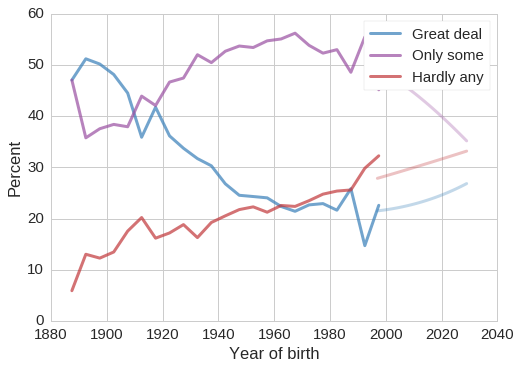

In [77]:
plot_conf(grouped_cohort)
plot_predictions(series_seq)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [78]:
run_models(sample, result_seq, 2016)

confident    22.780791
someconf     52.989084
noconf       24.062704
dtype: float64

In [79]:
years = np.arange(1973, 2040)
df = predict_by_year(sample, result_seq, years)

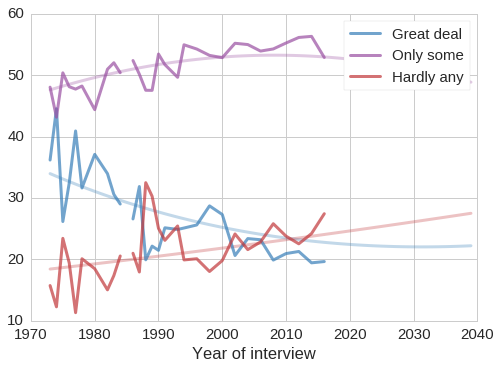

In [80]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)

plot_conf(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [81]:
sum(sample.bible.isnull())

28967

In [82]:
varnames = ['word', 'inspired', 'legends']

def create_bible_vars(df):
    df['word'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(sample)

In [83]:
def plot_bible(grouped):
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

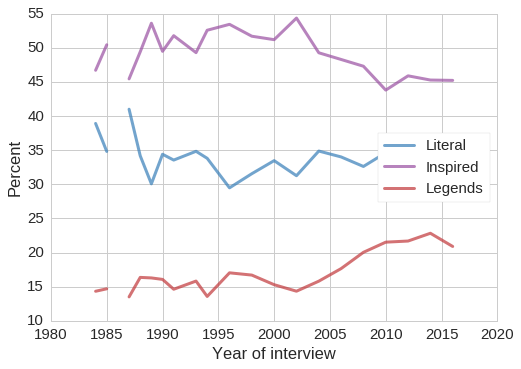

In [84]:
plot_bible(grouped_year)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

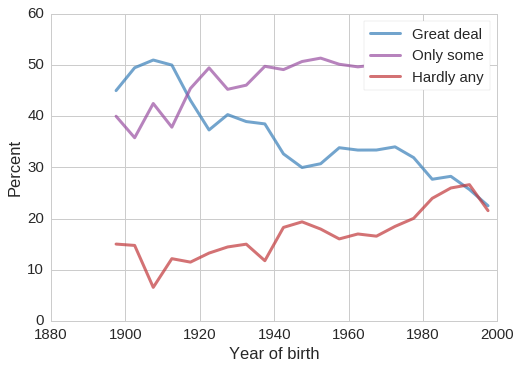

In [85]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [86]:
make_model(sample, 'word').summary()

Optimization terminated successfully.
         Current function value: 0.634981
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   word   No. Observations:                33028
Model:                          Logit   Df Residuals:                    33025
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                0.003999
Time:                        16:22:25   Log-Likelihood:                -20972.
converged:                       True   LL-Null:                       -21056.
                                        LLR p-value:                 2.716e-37
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7837      0.014    -54.772      0.000      -0.812      -0.756
cohort66      -0.0052      0.001     -5.689      0.000      -0.007      -0.003
cohort662      0.1750      0.050      3.499      0.000       0.077       0.273
==============================================================================
"""

In [87]:
make_model(sample, 'inspired').summary()

Optimization terminated successfully.
         Current function value: 0.692316
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               inspired   No. Observations:                33028
Model:                          Logit   Df Residuals:                    33025
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:               0.0008513
Time:                        16:22:25   Log-Likelihood:                -22866.
converged:                       True   LL-Null:                       -22885.
                                        LLR p-value:                 3.461e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0029      0.013     -0.215      0.830      -0.029       0.023
cohort66      -0.0025      0.001     -2.944      0.003      -0.004      -0.001
cohort662     -0.2815      0.048     -5.884      0.000      -0.375      -0.188
==============================================================================
"""

In [88]:
make_model(sample, 'legends').summary()

Optimization terminated successfully.
         Current function value: 0.462971
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                legends   No. Observations:                33028
Model:                          Logit   Df Residuals:                    33025
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 May 2017   Pseudo R-squ.:                0.005556
Time:                        16:22:26   Log-Likelihood:                -15291.
converged:                       True   LL-Null:                       -15376.
                                        LLR p-value:                 7.869e-38
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4693      0.017    -84.063      0.000      -1.504      -1.435
cohort66       0.0114      0.001     10.808      0.000       0.009       0.013
cohort662      0.1277      0.063      2.018      0.044       0.004       0.252
==============================================================================
"""

In [89]:
result_seq = [make_model(sample, var) for var in varnames]
series_seq = [make_predictions(results) for results in result_seq]

Optimization terminated successfully.
         Current function value: 0.634981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.462971
         Iterations 6


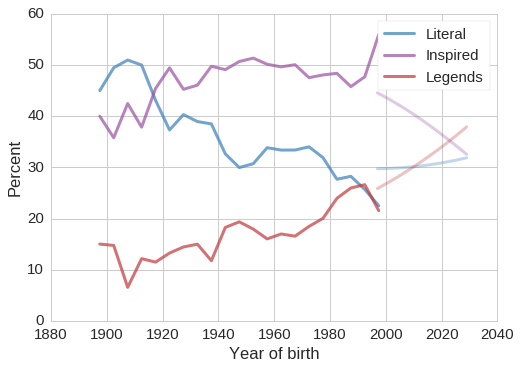

In [90]:
plot_bible(grouped_cohort)
plot_predictions(series_seq)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [91]:
run_models(sample, result_seq, 2016)

word        31.398743
inspired    48.443494
legends     20.170334
dtype: float64

In [92]:
years = np.arange(2017, 2040)
df = predict_by_year(sample, result_seq, years)

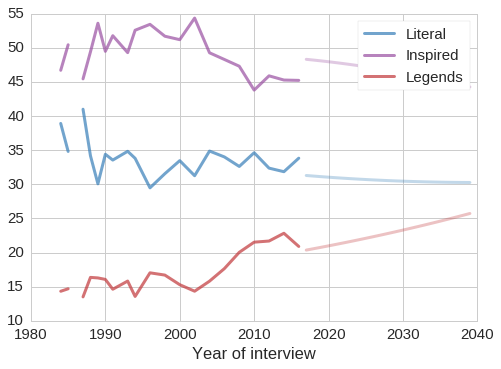

In [93]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)

plot_bible(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Older explorations

In [94]:
def percent_relig(df):
    """Compute the fraction in each major religious group.
    
    df: DataFrame
    
    returns: Series that maps from group name to percent.
    """
    return df[['prot', 'cath', 'other', 'none']].mean()

In [95]:
percent_relig(sample[sample.year==2016])

prot     0.497006
cath     0.236703
other    0.077844
none     0.204297
dtype: float64

In [96]:
recent = sample.loc[sample.year>=2000].copy()
recent.shape

(24146, 29)

In [97]:
percent_relig(recent)

prot     0.527706
cath     0.251553
other    0.089456
none     0.166529
dtype: float64

In [98]:
recent.year.mean()

2007.6164996272676

{'xscale': 'linear', 'yscale': 'linear'}

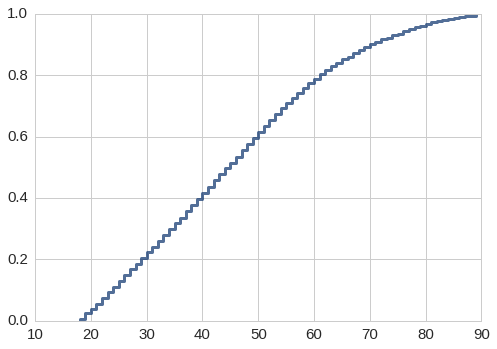

In [99]:
thinkplot.Cdf(thinkstats2.Cdf(recent.age))

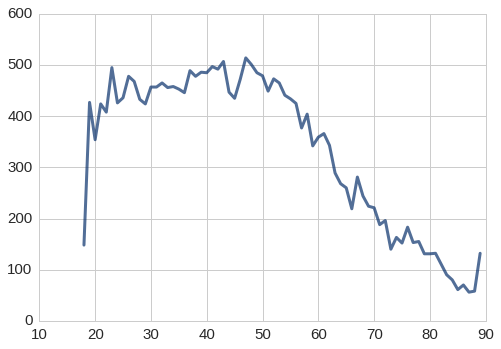

In [100]:
hist = thinkstats2.Hist(recent.age)
thinkplot.Pdf(hist)

In [101]:
def advance(df):
    """Ages a cohort by 1 year.
    
    df: DataFrame
    
    returns: new DataFrame
    """
    new = df.copy()
    new.year += 1
    new.age += 1
    
    return new

In [102]:
df = recent
pr = percent_relig(recent)
series = pd.DataFrame(columns=pr.index)

for _ in range(10):
    df = advance(df)
    year = df.year.mean()
    series.loc[year] = percent_relig(df)

In [103]:
series

,prot,cath,other,none
2008.6165,0.527706,0.251553,0.089456,0.166529
2009.6165,0.527706,0.251553,0.089456,0.166529
2010.6165,0.527706,0.251553,0.089456,0.166529
2011.6165,0.527706,0.251553,0.089456,0.166529
2012.6165,0.527706,0.251553,0.089456,0.166529
2013.6165,0.527706,0.251553,0.089456,0.166529
2014.6165,0.527706,0.251553,0.089456,0.166529
2015.6165,0.527706,0.251553,0.089456,0.166529
2016.6165,0.527706,0.251553,0.089456,0.166529
2017.6165,0.527706,0.251553,0.089456,0.166529


In [104]:
updated = advance(recent)

In [105]:
# https://www.cdc.gov/nchs/data/dvs/mortfinal2007_worktable23r.pdf

AGES = np.array([24, 34, 44, 54, 64, 74, 84])
RATES = np.array([79.9, 104.9, 184.4, 420.9, 877.7, 2011.3, 5011.6, 12946.5]) / 100000

In [106]:
def choose_dead(df):
    """Simulate deaths based on age-related rates.
    
    df: DataFrame
    
    returns: boolean array with True for dead
    """
    
    # look up the death rate for each respondent
    indices = np.searchsorted(AGES, df.age)
    rates = RATES[indices]
    
    # choose who dies
    dead = np.random.random(len(rates)) < rates
    return dead

In [107]:
dead = choose_dead(updated)
dead.sum()

284

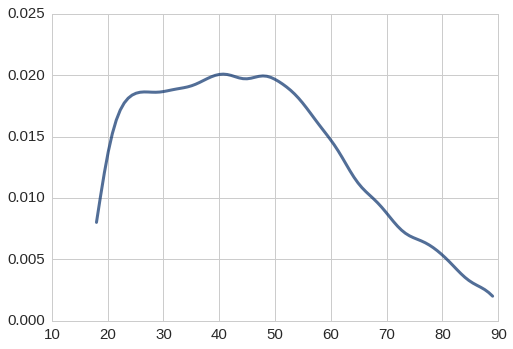

In [108]:
pdf = thinkstats2.EstimatedPdf(recent.age)
thinkplot.Pdf(pdf)

In [109]:
def replace(df, pdf):
    updated = advance(df)
    dead = choose_dead(updated)
    updated.loc[dead, 'age'] = np.nan
    
    pdf2 = thinkstats2.EstimatedPdf(updated.age.dropna())
    ages = np.arange(17, 92, 1)
    diffs = pdf.Density(ages) - pdf2.Density(ages)
    diffs[diffs<0] = 0
    pmf = thinkstats2.Pmf(dict(zip(ages, diffs)))
    thinkplot.Pdf(pmf)
    replacement_ages = pmf.Sample(dead.sum())
    updated.loc[dead, 'age'] = replacement_ages
    
    return updated

In [110]:
def replace(df, pmf):
    updated = advance(df)
    dead = choose_dead(updated)
    updated.loc[dead, 'age'] = 18
    updated['weight'] = pmf.Probs(updated.age.values)
    sample = thinkstats2.ResampleRowsWeighted(updated, column='weight')
    return sample

In [111]:
pmf = thinkstats2.Pmf(recent.age)

In [112]:
updated = replace(recent, pmf)
updated.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,nobelief,belief,strongbelief,confident,someconf,noconf,word,inspired,legends,weight
52610,2009,2.0,2.0,1979.0,30.0,2.135340,3,11.0,11,285,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.018927
56161,2013,NaN,2.0,1957.0,56.0,1.747975,1,2.0,14,1472,...,0.0,0.0,1.0,NaN,NaN,NaN,0.0,1.0,0.0,0.017601
57047,2015,3.0,2.0,1958.0,57.0,0.448002,2,1.0,12,1697,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.015613
41329,2003,NaN,NaN,1965.0,38.0,1.115600,1,1.0,17,1099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019796
46745,2007,2.0,NaN,1940.0,67.0,0.859300,2,1.0,14,2624,...,0.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,0.011638


In [113]:
updated = replace(updated, pmf)

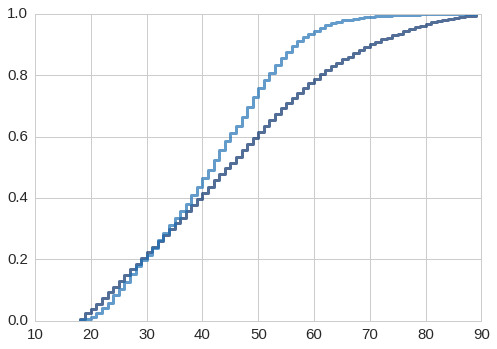

In [114]:
cdf1 = thinkstats2.Cdf(recent.age)
cdf2 = thinkstats2.Cdf(updated.age)
thinkplot.Cdfs([cdf1, cdf2])

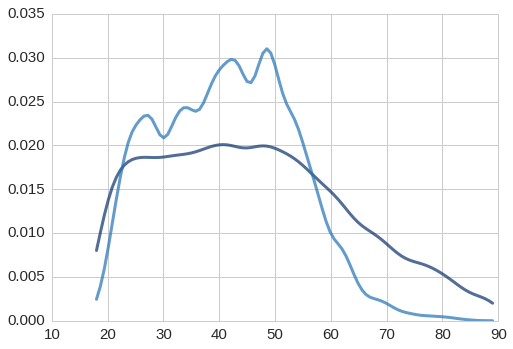

In [115]:
pdf1 = thinkstats2.EstimatedPdf(recent.age)
pdf2 = thinkstats2.EstimatedPdf(updated.age)
thinkplot.Pdfs([pdf1, pdf2])

In [116]:
xs = np.arange(17, 92, 1)
xs

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91])